# Libraries

In [1]:
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import Model, Sequential, layers, losses
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Import MNIST

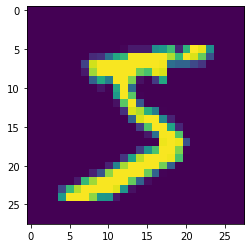

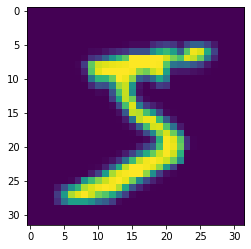

In [2]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

img = X_train[0]
plt.imshow(img)
plt.show()

img = cv2.resize(img, (32, 32))
plt.imshow(img)
plt.show()

In [3]:
def resize(img_array, IMG_SIZE: int):
    tmp = np.empty((img_array.shape[0], IMG_SIZE, IMG_SIZE))

    for i in tqdm(range(len(img_array))):
        img = img_array[i].astype("uint8")
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img.astype("float64") / 255.0
        tmp[i] = img
    return tmp

X_train = resize(X_train, 32)
X_test = resize(X_test, 32)

# stack 1 channel to 3 channels
X_train = np.stack((X_train, ) * 3, axis = -1)
X_test = np.stack((X_test, ) * 3, axis = -1)

print(X_train.shape)
print(X_test.shape)

100%|██████████| 10000/10000 [00:00<00:00, 28676.14it/s]


(60000, 32, 32, 3)
(10000, 32, 32, 3)


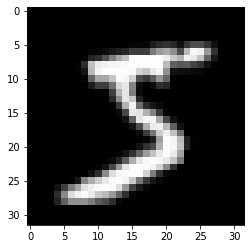

[5 0 4 ... 5 6 8]


In [4]:
img = X_train[0]
plt.imshow(img)
plt.show()

print(y_train)

# Custom VGG Model

In [5]:
vgg_model = keras.applications.VGG19(include_top = False, input_shape = (32, 32, 3))
print(vgg_model.summary())

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [6]:
custom_vgg_model = Sequential([
    vgg_model,
    layers.Flatten(),
    layers.Dense(1024, activation = "relu"),
    layers.Dense(512, activation = "relu"),
    layers.Dense(128, activation = "relu"),
    layers.Dropout(0.2),
    layers.Dense(10, activation = "softmax"),
])

print(custom_vgg_model.summary())

custom_vgg_model.compile(
    loss = losses.SparseCategoricalCrossentropy(from_logits = False),
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    metrics = ["accuracy"]
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                1

# Train Model

In [7]:
es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=5)
mc = ModelCheckpoint(filepath='mnist-vgg19.h5', verbose=1, monitor='val_accuracy')
cb = [es, mc]

In [8]:
history = custom_vgg_model.fit(
    X_train, y_train,
    epochs = 10, batch_size = 256,
    validation_data = (X_test, y_test),
    callbacks = cb
)

Epoch 1/10
235/235 [==============================] - ETA: 0s - loss: 1.3180 - accuracy: 0.5003WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy

Epoch 1: saving model to mnist-vgg19.h5
235/235 [==============================] - 67s 263ms/step - loss: 1.3180 - accuracy: 0.5003 - val_loss: 0.5255 - val_accuracy: 0.8321
Epoch 2/10
235/235 [==============================] - ETA: 0s - loss: 0.3954 - accuracy: 0.9028WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy

Epoch 2: saving model to mnist-vgg19.h5
235/235 [==============================] - 59s 253ms/step - loss: 0.3954 - accuracy: 0.9028 - val_loss: 0.5589 - val_accuracy: 0.8128
Epoch 3/10
235/235 [==============================] - ETA: 0s - loss: 0.2246 - accuracy: 0.9483WARNING:tensorflow:Early stopping conditioned on metric `val_acc` w

In [9]:
custom_vgg_model.evaluate(X_test, y_test, verbose = 1)

313/313 [==============================] - 8s 24ms/step - loss: 0.0517 - accuracy: 0.9889


[0.05172749608755112, 0.9889000058174133]